In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import sqlite3 
import warnings
from sqlalchemy import create_engine
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


In [2]:
engine = create_engine("sqlite:///MTA.db")

db = pd.read_sql('SELECT * FROM MTA;', engine)
db

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,03:00:00,REGULAR,4945474,1675324
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,07:00:00,REGULAR,4945478,1675333
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,11:00:00,REGULAR,4945515,1675364
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,15:00:00,REGULAR,4945679,1675408
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,19:00:00,REGULAR,4946006,1675469
...,...,...,...,...,...,...,...,...,...,...,...
3088408,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,05:00:00,REGULAR,5554,219
3088409,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,09:00:00,REGULAR,5554,219
3088410,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,13:00:00,REGULAR,5554,219
3088411,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,17:00:00,REGULAR,5554,219


In [2]:
#get data from link
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [150110, 150117, 150124, 150131, 150207, 150214, 150221, 150228, 150704, 150711,150718, 150725, 150801, 150808, 150815, 150822]
df = get_data(week_nums)
# create dataframe
df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,03:00:00,REGULAR,4945474,1675324
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,07:00:00,REGULAR,4945478,1675333
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,11:00:00,REGULAR,4945515,1675364
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,15:00:00,REGULAR,4945679,1675408
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,01/03/2015,19:00:00,REGULAR,4946006,1675469
...,...,...,...,...,...,...,...,...,...,...,...
192667,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,05:00:00,REGULAR,5554,219
192668,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,09:00:00,REGULAR,5554,219
192669,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,13:00:00,REGULAR,5554,219
192670,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,08/21/2015,17:00:00,REGULAR,5554,219


In [12]:
#winter season 
df.columns = [column.strip() for column in df.columns]

def x(start_date, end_date):
    
    #making a mask to show specific columns & assigning it to variable   
    mask = (df['STATION'] == 'LEXINGTON AVE') & (df['DATE'] >= start_date) & (df['DATE'] <= end_date)
    q = df[mask].copy(deep=True)
    
    #getting the true values of 1 day entries & exits
    daily_entries = (q.groupby(['DATE','C/A','UNIT','SCP','LINENAME','DIVISION']).ENTRIES.diff().reset_index().ENTRIES)
    daily_exits = (q.groupby(['DATE','C/A','UNIT','SCP','LINENAME','DIVISION']).EXITS.diff().reset_index().EXITS)
    
    q['daily_entries'] = daily_entries
    q['daily_exits'] = daily_exits
    q['diff'] = abs(daily_entries - daily_exits)
    q.dropna(subset = ['diff'], inplace=True)
    qmask = ((q['DATE'] >= start_date) & (q['DATE'] <= end_date))
    
    # returning the Median
    return q[qmask].groupby(['DATE'])['diff'].sum().median()




In [13]:
# set weeks order 
dates = [
    ['01/03/2015','01/09/2015'],['01/10/2015','01/16/2015'],['01/17/2015','01/23/2015'],['01/24/2015','01/30/2015'],['01/31/2015','02/06/2015'],['02/07/2015','02/13/2015'],['02/14/2015','02/20/2015']]


In [14]:
# assign all to a variable 
output = pd.DataFrame([x(date[0], date[1])  for date in dates],columns = ['Median'])

# set the rows names
output.index = ["week1","week2","week3","week4","week5","week6","week7"]



In [15]:
output['Median'] = output['Median']
output.columns = ['MEDIAN']
output #winter

,MEDIAN
week1,15510.0
week2,15980.0
week3,15820.0
week4,14554.0
week5,15657.0
week6,15995.0
week7,15129.0


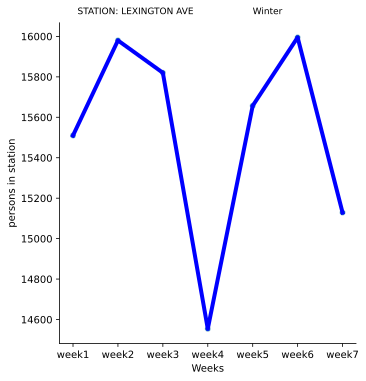

In [16]:
#show weekly number of persons in one station 
sns.relplot(x = ["week1","week2","week3","week4","week5","week6","week7"], y = output.MEDIAN)

#plot Design & label
plt.plot(output.MEDIAN, linewidth = 4, color = 'blue');
plt.ylabel('persons in station');
plt.xlabel('Weeks');
plt.text(0.1,16110,'STATION: LEXINGTON AVE',fontsize = 9,color = 'black');
plt.text(4,16110,'Winter',fontsize = 9,color = 'black');

In [17]:
#summer season 
df.columns = [column.strip() for column in df.columns]

def x(start_date, end_date):
    
    #making a mask to show specific columns & assignign it to varible 
    mask = (df['STATION'] == 'LEXINGTON AVE') & (df['DATE'] >= start_date) & (df['DATE'] <= end_date)
    q = df[mask].copy(deep=True)
    
    #getting the true values of 1 day entries & exits
    daily_entries = (q.groupby(['DATE','C/A','UNIT','SCP','LINENAME','DIVISION']).ENTRIES.diff().reset_index().ENTRIES)
    daily_exits = (q.groupby(['DATE','C/A','UNIT','SCP','LINENAME','DIVISION']).EXITS.diff().reset_index().EXITS)
    
    q['daily_entries'] = daily_entries
    q['daily_exits'] = daily_exits
    q['diff'] = abs(daily_entries - daily_exits)
    q.dropna(subset = ['diff'], inplace=True)
    qmask = ((q['DATE'] >= start_date) & (q['DATE'] <= end_date))
    
    # returning the Median
    return q[qmask].groupby(['DATE'])['diff'].sum().median()




In [18]:
# set weeks order 
dates = [
    ['07/04/2015','07/10/2015'],['07/11/2015','07/17/2015'],['07/18/2015','07/24/2015'],['07/25/2015','07/31/2015'],['08/01/2015','08/07/2015'],['08/08/2015','08/14/2015'],['08/15/2015','08/21/2015']]


In [19]:
# assign all to a varible
output = pd.DataFrame([x(date[0], date[1])  for date in dates],columns = ['Median'])

# set the rows names
output.index = ["week1","week2","week3","week4","week5","week6","week7"]



In [20]:
output['Median'] = output['Median']
output.columns = ['MEDIAN']
output #summer

,MEDIAN
week1,14275.0
week2,14682.0
week3,14726.0
week4,14432.0
week5,14348.0
week6,14067.0
week7,13711.0


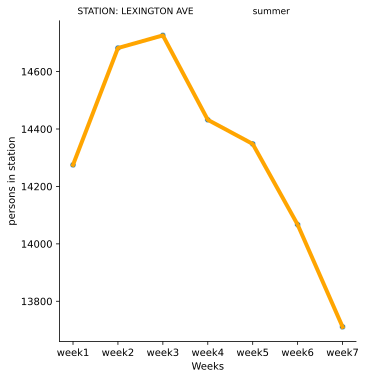

In [42]:
#show weekly number of persons in one station 
sns.relplot(x = ["week1","week2","week3","week4","week5","week6","week7"], y = output.MEDIAN)

#plot Design & label
plt.plot(output.MEDIAN, linewidth = 4, color = 'orange');
plt.ylabel('persons in station');
plt.xlabel('Weeks');
plt.text(0.1,14800,'STATION: LEXINGTON AVE',fontsize = 9,color = 'black');
plt.text(4,14800,'summer',fontsize = 9,color = 'black');